## Pump it up! Modeling work

In [1]:
from __future__ import print_function

import pandas as pd
import re
from itertools import combinations
import collections

# import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix

import patsy
import numpy as np
import matplotlib.pyplot as plt
from impute import imputeTrain
%matplotlib inline

# TODO: make impute_func work, need workaround on the dataframe splitting

In [2]:
class PumpModel(object):
    def __init__(self,
                 csv_train_X='../data/train_X.csv',
                 csv_train_y='../data/train_y.csv'):
        """
        input:
            csv_train_X - file location
            csv_train_y - file location
        """
        self.csv_train_X = csv_train_X
        self.csv_train_y = csv_train_y
        self.df = self.read_n_convert_functional_labels()
        print('PumpModel obj. initialzed. data read into df. \n'
              'PumpModel.run_batch() to see quick analysis results.')

    def run_batch(self, flag_interactions=False, flag_clean_features=False):
        print('reading and transforming data...')
        self.ready_for_model(flag_interactions, flag_clean_features)

        print('split train and test, testing models...')
        self.run_models()

        # it looks RandomForest does us better, let's try a new parameter
        print('\ntrying RandomForestClassifier with n_estimators=200...')
        model = RandomForestClassifier(n_estimators=200)
        self.split_n_fit(model)

        # let's try another new parameter
        print('\ntrying RandomForestClassifier with n_estimators=300...')
        model = RandomForestClassifier(n_estimators=300)
        self.split_n_fit(model)

        # also use KFold to make sure we cross validate
        print('\ntrying RandomForestClassifier with n_estimators=200 '
              'using KFold...')
        model = RandomForestClassifier(n_estimators=200)
        self.run_KFold(model)

        # so far, we only used the automatic feature selection.
        # To get some idea of what feature really matters, we can check
        # the importance of features
        print('\nsort and barplot features...')
        self.sort_feature_imporances()

    def read_n_convert_functional_labels(self):
        """
            1. read training data sets X and y
            2. merge these two data sets
            3. convert functional to 2, non-functional to 0,
            functional-needs-repaird to 1, new column name 'status'
            return: dataframe df
        """

        df_X = pd.read_csv(self.csv_train_X)
        df_y = pd.read_csv(self.csv_train_y)
        df = pd.merge(df_y, df_X, how='left', on='id')
        df.loc[:, 'status'] = df.status_group
        df.loc[df.status.str.startswith('functional needs'), 'status'] = 1
        df.loc[df.status_group.str.startswith('non'), 'status'] = 0
        df.loc[~df.status.str.startswith('functional').isnull(), 'status'] = 2
        df.status = df.status.astype(int)
        return df

    def ready_for_model(self,
                        flag_interactions=False,
                        flag_clean_features=False):
        """
        process data

        input:
            flag_iteractions - True to add columns of additional feature
                                interactions
            flag_clean_features - True to keep most common N categories in
                                the features with too many of them

        create/modify:
            self.cols_continuous
            self.cols_categorical
            self.cols_giveup
            self.df_X
            self.df_y
            self.X
            self.y
            self.cols_X
            self.r_formula
        """

        N = 25
        if flag_clean_features:
            self.df = self.clean_features(N=N)

        # seperate features to continuous, categorical
        self.cols_continuous, self.cols_categorical, self.cols_giveup = \
            self.preprocess_features(N=N)

        # remove the labels
        for to_remove in ['id', 'status', 'status_group']:
            try:
                self.cols_continuous.remove(to_remove)
            except ValueError:
                pass
            try:
                self.cols_categorical.remove(to_remove)
            except ValueError:
                pass

        # convert df to X, y by patsy
        self.r_formula = ('status ~' +
                          ' + '.join(self.cols_continuous) +
                          ' + C(' + ') + C('.join(self.cols_categorical) + ')'
                          )
        self.df_y, self.df_X = patsy.dmatrices(self.r_formula,
                                               data=self.df,
                                               return_type='dataframe')

        # include interactions of features if flagged
        if flag_interactions:
            self.df_X = self.interactions(self.df_X)

        self.cols_X = self.df_X.columns
        self.X = self.df_X.values
        self.y = self.df_y.values
        return (self.X, self.y)

    def clean_features(self, N=25, feat_list=['scheme_name']):
        """
        Keep the most common entries for some features
        default for now just include scheme_name since it seems to
        be particularly important
        """

        for feat in feat_list:
            least_common = [x[0] for x in collections.Counter(self.df[feat]).
                            most_common()[N:-1]]
            for label in least_common:
                self.df.loc[:, feat] = self.df[feat].replace(label, 'NaN')
        return self.df

    def preprocess_features(self, N=25):
        """ pre-process,  collect columns based type (continuous, categorical,
        giveup (too many categories))
            input:
                N - maximum num of categories accepted in one feature
            return:
                cols_continuos - list
                cols_categorical - list
                cols_giveup - list
        """

        self.cols_continuous = []
        self.cols_categorical = []
        self.cols_giveup = []

        for c in self.df:
            if c.endswith('_code'):
                self.cols_categorical.append(c)
            elif self.df[c].dtype in [int, float]:
                self.cols_continuous.append(c)
            elif self.df[c].dtype == object:
                if self.df[c].nunique() < N + 2:
                    self.cols_categorical.append(c)
                else:
                    self.cols_giveup.append(c)
        return (self.cols_continuous, self.cols_categorical, self.cols_giveup)

    def interactions(self, df_X):
        """ input: df_X including the transposed dummy columns
            return: df_X with feature interactions
        """
        cols_X = df_X.columns
        cols_X = cols_X.drop('Intercept')
        cols_X_combo = list(combinations(cols_X, 2))

        combo_keep = []
        for c1, c2 in cols_X_combo:
            # ignore dummies X dummies interactions
            if re.search("\[T\.", c1) and re.search("\[T\.", c2):
                continue
            combo_keep.append([c1, c2])

        for c1, c2 in combo_keep:
            df_X[c1 + '_X_' + c2] = df_X[c1] * df_X[c2]

        return df_X

    def split_n_fit(self, model, X=None, y=None):
        """ given model, X, y, print score of the fit on test """

        if X is None or not X.any():
            X = self.X
        if y is None or not y.any():
            y = self.y
        if X is None or y is None:
            raise Exception('Need to run reday_for_model first')

        X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(),
                                                            random_state=42)
        model.fit(X_train, y_train)
        print()
        print('{}'.format(model).split('(')[0])
        print(model.score(X_test, y_test))
        self.X_test = X_test
        self.y_test = y_test
        self.model_fitted = model
        self.show_confusion_matrix()

    def run_models(self, X=None, y=None):
        if X is None or not X.any():
            X = self.X
        if y is None or not y.any():
            y = self.y
        if X is None or y is None:
            raise Exception('Need to run reday_for_model first')

        for model in [LogisticRegression(), DecisionTreeClassifier(),
                      KNeighborsClassifier(), GaussianNB(),
                      RandomForestClassifier()]:
            self.split_n_fit(model, X, y)

    def run_KFold(self, model, X=None, y=None, n_folds=5):
        """ given model, X, y, print score of the fit on KFold test"""
        if X is None or not X.any():
            X = self.X
        if y is None or not y.any():
            y = self.y
        if X is None or y is None:
            raise Exception('Need to run reday_for_model first')

        y = y.ravel()
        scores = []
        cnt = 0
        for train_index, test_index in KFold(len(y), n_folds=n_folds):
            X_train = X[train_index]
            y_train = y[train_index]
            X_test = X[test_index]
            y_test = y[test_index]
            model.fit(X_train, y_train)
            score = model.score(X_test, y_test)
            scores.append(score)
            cnt += 1
            print('fold', cnt, ':', score)

        print('avg score:', np.mean(scores))

        # keep a copy of the train, test set
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.model_fitted = model
        self.show_confusion_matrix()

    def sort_feature_imporances(self, model_fitted=None):
        """ input:
                fitted_model: model has to be ensemble or tree type and fitted
                cols_X: list of features
            print:
                features ranked by importance
            plot:
                the first 20 important features
        """

        # in tree and ensemble type of models, we can use feature_importances_
        if not model_fitted:
            model_fitted = self.model_fitted
        cols_X = self.df_X.columns
        importances = model_fitted.feature_importances_
        std = np.std([tree.feature_importances_
                      for tree in model_fitted.estimators_],
                     axis=0)
        indices = importances.argsort()[::-1]
        print("Features ranked by importance:")
        for i, (feature, importance) in enumerate(zip(cols_X[indices],
                                                      importances[indices])):
            print(i, feature, importance)

        # just plot the first 20
        n_first = 20
        plt.figure(figsize=[15, 10])
        plt.bar(range(n_first), importances[indices[0:20]], color='g',
                yerr=std[indices[0:20]], align='center')
        plt.xticks(range(n_first), cols_X[indices[0:20]], rotation=60)
        plt.tight_layout()
        plt.show()

    def show_confusion_matrix(self):
        print('confusion matrix:')
        y_pred = self.model_fitted.predict(self.X_test)
        y_actual = self.y_test

        # get y_pred and y_actual
        # convert y's to binary
        # we want True means not-functional or need-repair
        # (where the govern. needs to send people) , False: functional
        # In our data, 2: functional 1: need repair 0: non-functional

        y_pred_bin = (y_pred < 2)
        y_actual_bin = (y_actual < 2)
        conf = confusion_matrix(y_actual_bin, y_pred_bin)

        TP = conf[0, 0]
        FN = conf[0, 1]
        FP = conf[1, 0]
        TN = conf[1, 1]
        recall = TP * 1. / (TP + FN)
        print("recall TP / (TP + FN)", recall)
        precision = TP * 1. / (TP + FP)
        print("precision TP / (TP + FP)", precision)

In [3]:
def main():
    print('run batch data manipulations and test on models')

In [4]:
    pm = PumpModel()

PumpModel obj. initialzed. data read into df. 
PumpModel.run_batch() to see quick analysis results.


reading and transforming data...
split train and test, testing models...

LogisticRegression
0.733568734451
confusion matrix:
recall TP / (TP + FN) 0.912645348837
precision TP / (TP + FP) 0.709732112581

DecisionTreeClassifier
0.754594334323
confusion matrix:
recall TP / (TP + FN) 0.792877906977
precision TP / (TP + FP) 0.803387334315

KNeighborsClassifier
0.689190273654
confusion matrix:
recall TP / (TP + FN) 0.771075581395
precision TP / (TP + FP) 0.730917608157

GaussianNB
0.500601877859
confusion matrix:
recall TP / (TP + FN) 0.507122093023
precision TP / (TP + FP) 0.734217171717

RandomForestClassifier
0.790386004334
confusion matrix:
recall TP / (TP + FN) 0.839534883721
precision TP / (TP + FP) 0.823026503277

trying RandomForestClassifier with n_estimators=200...

RandomForestClassifier
0.804670572185
confusion matrix:
recall TP / (TP + FN) 0.872529069767
precision TP / (TP + FP) 0.81996994946

trying RandomForestClassifier with n_estimators=300...

RandomForestClassifier
0.8067

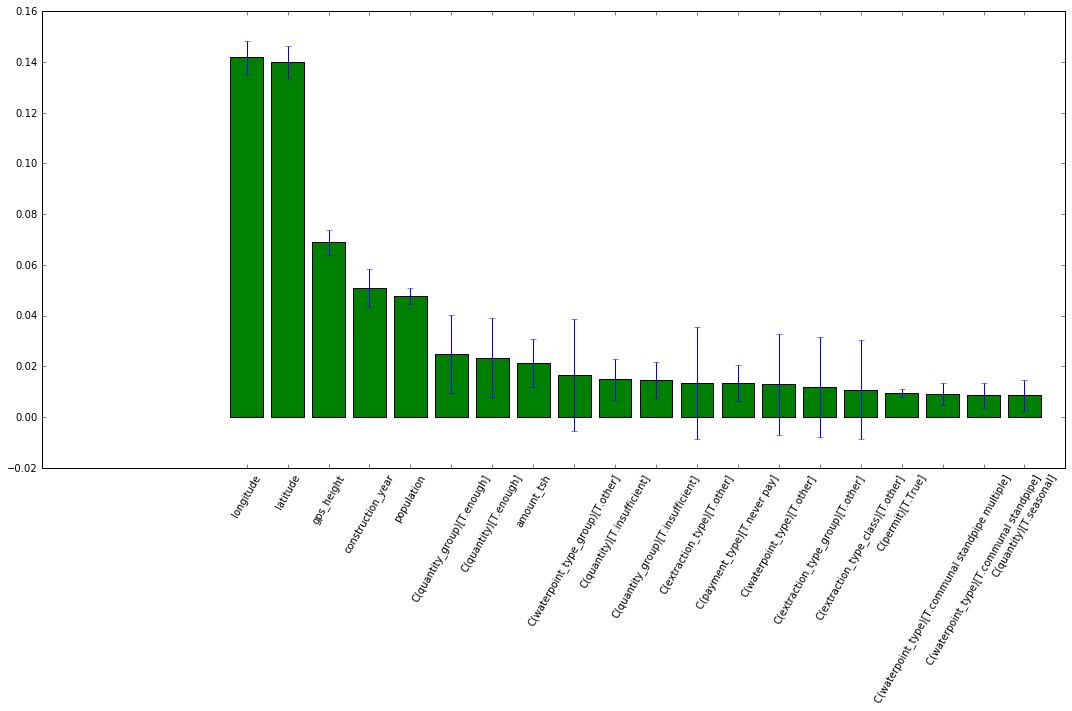

In [5]:
    # first batch
    pm.run_batch()

reading and transforming data...
split train and test, testing models...

LogisticRegression
0.841296928328
confusion matrix:
recall TP / (TP + FN) 0.916449086162
precision TP / (TP + FP) 0.861349693252

DecisionTreeClassifier
0.811433447099
confusion matrix:
recall TP / (TP + FN) 0.849869451697
precision TP / (TP + FP) 0.876177658143

KNeighborsClassifier
0.765358361775
confusion matrix:
recall TP / (TP + FN) 0.860313315927
precision TP / (TP + FP) 0.809582309582

GaussianNB
0.594709897611
confusion matrix:
recall TP / (TP + FN) 0.574412532637
precision TP / (TP + FP) 0.84452975048

RandomForestClassifier
0.848976109215
confusion matrix:
recall TP / (TP + FN) 0.890339425587
precision TP / (TP + FP) 0.893840104849

trying RandomForestClassifier with n_estimators=200...

RandomForestClassifier
0.858361774744
confusion matrix:
recall TP / (TP + FN) 0.913838120104
precision TP / (TP + FP) 0.887198986058

trying RandomForestClassifier with n_estimators=300...

RandomForestClassifier
0.8558

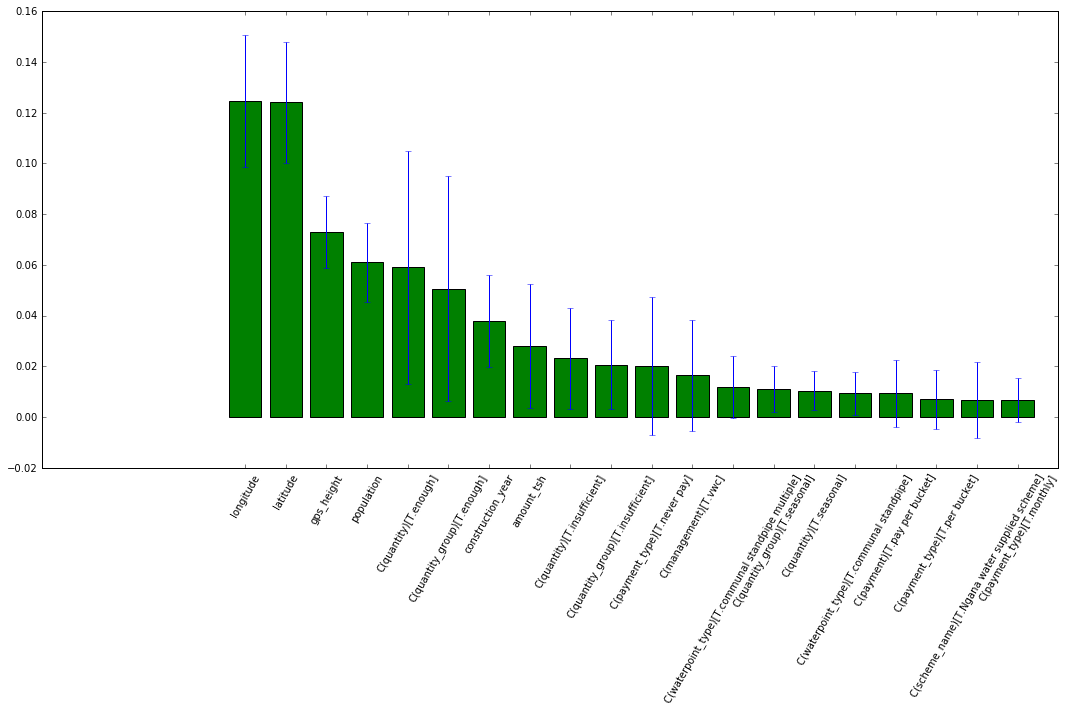

In [6]:
    # second batch with clean_features
    pm.run_batch(flag_interactions=False, flag_clean_features=True)

reading and transforming data...
split train and test, testing models...

LogisticRegression
0.789249146758
confusion matrix:
recall TP / (TP + FN) 0.891644908616
precision TP / (TP + FP) 0.819927971188

DecisionTreeClassifier
0.815699658703
confusion matrix:
recall TP / (TP + FN) 0.849869451697
precision TP / (TP + FP) 0.87972972973

KNeighborsClassifier
0.763651877133
confusion matrix:
recall TP / (TP + FN) 0.860313315927
precision TP / (TP + FP) 0.807598039216

GaussianNB
0.317406143345
confusion matrix:
recall TP / (TP + FN) 0.0522193211488
precision TP / (TP + FP) 0.833333333333

RandomForestClassifier
0.839590443686
confusion matrix:
recall TP / (TP + FN) 0.890339425587
precision TP / (TP + FP) 0.881136950904

trying RandomForestClassifier with n_estimators=200...

RandomForestClassifier
0.856655290102
confusion matrix:
recall TP / (TP + FN) 0.913838120104
precision TP / (TP + FP) 0.884955752212

trying RandomForestClassifier with n_estimators=300...

RandomForestClassifier
0.859

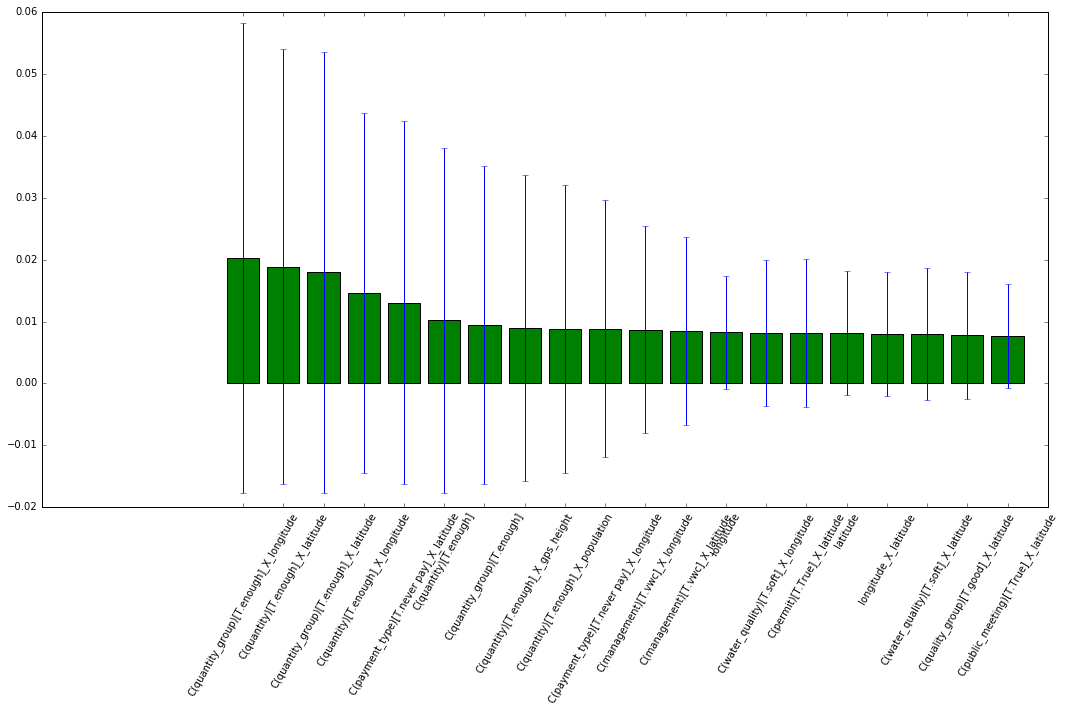

In [7]:
    # 3rd batch with feature interactions
    pm.run_batch(flag_interactions=True, flag_clean_features=False)

reading and transforming data...
split train and test, testing models...

LogisticRegression
0.775725593668
confusion matrix:
recall TP / (TP + FN) 0.888121546961
precision TP / (TP + FP) 0.79776674938

DecisionTreeClassifier
0.818821459982
confusion matrix:
recall TP / (TP + FN) 0.866022099448
precision TP / (TP + FP) 0.864827586207

KNeighborsClassifier
0.759014951627
confusion matrix:
recall TP / (TP + FN) 0.849447513812
precision TP / (TP + FP) 0.809210526316

GaussianNB
0.334212840809
confusion matrix:
recall TP / (TP + FN) 0.0953038674033
precision TP / (TP + FP) 0.793103448276

RandomForestClassifier
0.84872471416
confusion matrix:
recall TP / (TP + FN) 0.903314917127
precision TP / (TP + FP) 0.877852348993

trying RandomForestClassifier with n_estimators=200...

RandomForestClassifier
0.863676341249
confusion matrix:
recall TP / (TP + FN) 0.933701657459
precision TP / (TP + FP) 0.87338501292

trying RandomForestClassifier with n_estimators=300...

RandomForestClassifier
0.86455

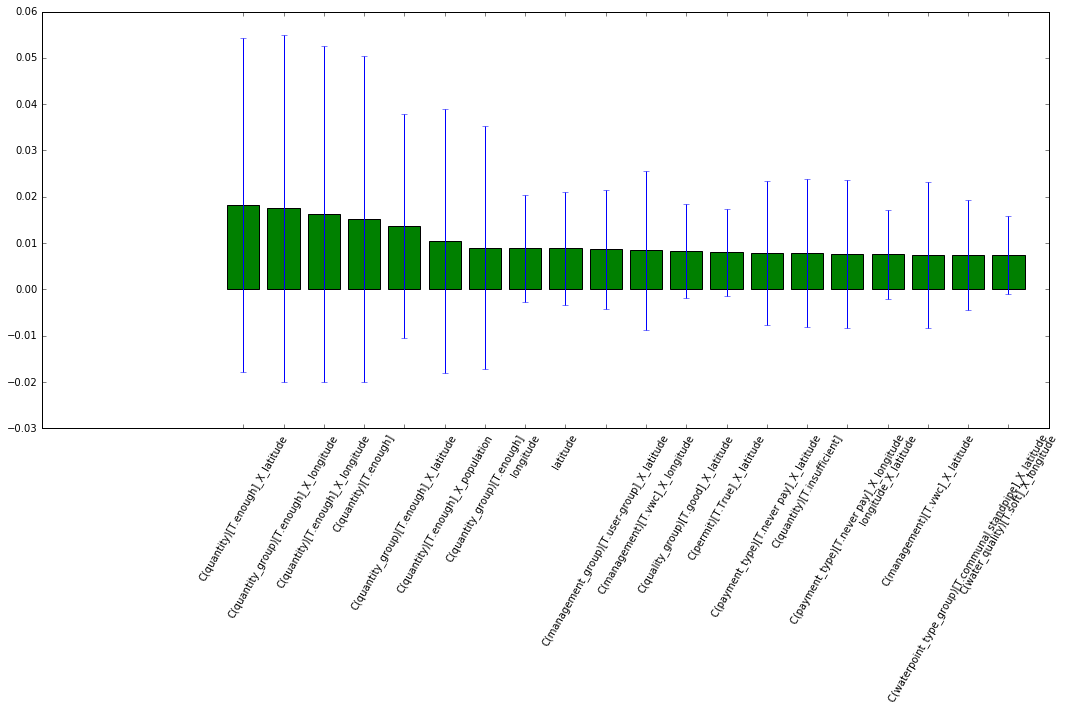

In [8]:
    # 4th batch with feature interactions and clean_features
    pm.run_batch(flag_interactions=True, flag_clean_features=True)

In [ ]:
if __name__ == "__main__":
    main()